In [1]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa as tsa
import statsmodels.tsa.api as smt 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import os.path
import sys
import re

# Домашнее задание "Случайные марковские процессы"

— Скачайте текст войны и мир (ссылка на github и гугл диск). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов

— Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

## 1 Генерация текста на основе книги "Война и мир"
### 1.1 Подготовка текстовых данных

In [2]:
book_dir = 'war_and_peace'
text = ""
for bookfile in [book_dir + os.sep + filename for filename in os.listdir(book_dir)]:
    with open(bookfile, 'r', encoding='utf-8') as f:
        text += f.read()
        
text_filtered = text.lower()
# Заменим все символы перевода строки на один пробел
text_filtered = re.sub(r'\n+', ' ', text_filtered)
# Оставляем только русские буквы и пробелы
text_filtered = re.sub(r'[^а-я ]', '', text_filtered)
# Все длинные пробелы заменяем одним пробелом
text_filtered = re.sub(r'( )\1+', ' ', text_filtered)
# Удаляем пробелы по краям текста
text_filtered = text_filtered.strip()

### 1.2 Создание матрицы переходных вероятностей

In [3]:
RUSSIAN = sorted(list(set(text_filtered)))
probabilities = np.zeros([len(RUSSIAN),len(RUSSIAN)])
POS = {symbol: position for position, symbol in enumerate(RUSSIAN)}

In [4]:
for cp, cn in zip(text_filtered[:-1], text_filtered[1:]):
    probabilities[POS[cp], POS[cn]] += 1
    
probabilities = probabilities / probabilities.sum(axis=1)[:,np.newaxis]

### 1.3 Вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р

В данном случае решаем задачу достигнуть из состояния буквы п в состояние буквы р за 3 шага.

Искомая вероятность для каждой фразы будет выглядеть так: Palpha * Pп,symbol_1 * Pп,symbol_2,р
Palpha - вероятность начального состояние цепи.
symbol_1 и symbol_2 - символы из словаря RUSSIAN

Сумма вероятностей всех комбинаций symbol_1 и symbol_2 даст итоговую вероятность встретить искомую фразу.

In [5]:
start = POS['п']
end = POS['р']
prior = 1 / len(RUSSIAN)
probas = []

for symbol_1 in RUSSIAN:
    for symbol_2 in RUSSIAN:
        proba = prior * probabilities[start, POS[symbol_1]] * probabilities[POS[symbol_1], POS[symbol_2]] * probabilities[POS[symbol_2], end]
        if proba > 0:
            probas.append(('п'+symbol_1+symbol_2+'п', proba))

full_proba_1 = sum([proba for _, proba in probas])
print('Полная вероятность: ', full_proba_1, '\n')

# Удалим все слова с пробелами
probas = [(word, proba) for word, proba in probas if ' ' not in word]
probas = sorted(probas, key=lambda x: x[1], reverse=True)
for word, proba in probas[:30]:
    print(f'{word}: {proba}')

Полная вероятность:  0.0009817122115138063 

преп: 0.00012337205335635315
проп: 9.413595775881725e-05
прап: 7.639833606540522e-05
потп: 4.3554167935188125e-05
попп: 4.191365372610907e-05
погп: 3.95534252258386e-05
подп: 3.923887821245803e-05
побп: 3.0285881717201467e-05
поеп: 2.651642314621323e-05
пруп: 1.5699879646934178e-05
повп: 1.466958836637222e-05
пепп: 1.21129839822231e-05
пегп: 1.1418396362808416e-05
покп: 1.0040516782893334e-05
прип: 1.0024634383602259e-05
пофп: 9.919656983390814e-06
петп: 9.173757344868276e-06
педп: 8.706208642576472e-06
плоп: 8.677334532158587e-06
плеп: 8.566646711708803e-06
пьеп: 8.033192890239137e-06
пееп: 7.1915239547353635e-06
пупп: 6.951542370599179e-06
пртп: 6.374562348347458e-06
прып: 6.270431031454998e-06
плап: 6.2646303150348724e-06
патп: 5.689368647492535e-06
папп: 5.636299369844664e-06
посп: 5.305166468895215e-06
прдп: 5.277381590340464e-06


### 1.4 Генерация слова, начинающегося с буквы “Б” и имеющее длину 8-мь символов

In [6]:
start = 'б'
word_length = 8
words_count=10
result = []

for _ in range(words_count):
    word = [start]
    for _ in range(word_length):
        index = POS[word[-1]]
        next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
        word.append(next_char)
    result.append(''.join(word))
    
for num, word in enumerate(result):
    print(f'{num}: {word}')

0: бемниеро 
1: бе умо ба
2: бе пра не
3: бспо чтон
4: быхрылилю
5: бокиенымо
6: берад о в
7: бретутязк
8: бы б стри
9: брыл небо


## 2 Наивный прогноз ряда ежемесячных ограблений Бостона с помощью скрытой модели Маркова

In [7]:
airlines_passengers = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
series = airlines_passengers['Count']
airlines_passengers[:6]

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43
5,1966-06,38


In [8]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    test_stationarity(y)
        
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()

Results of Dickey-Fuller Test:
Test Statistic                   1.001102
p-value                          0.994278
#Lags Used                      11.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


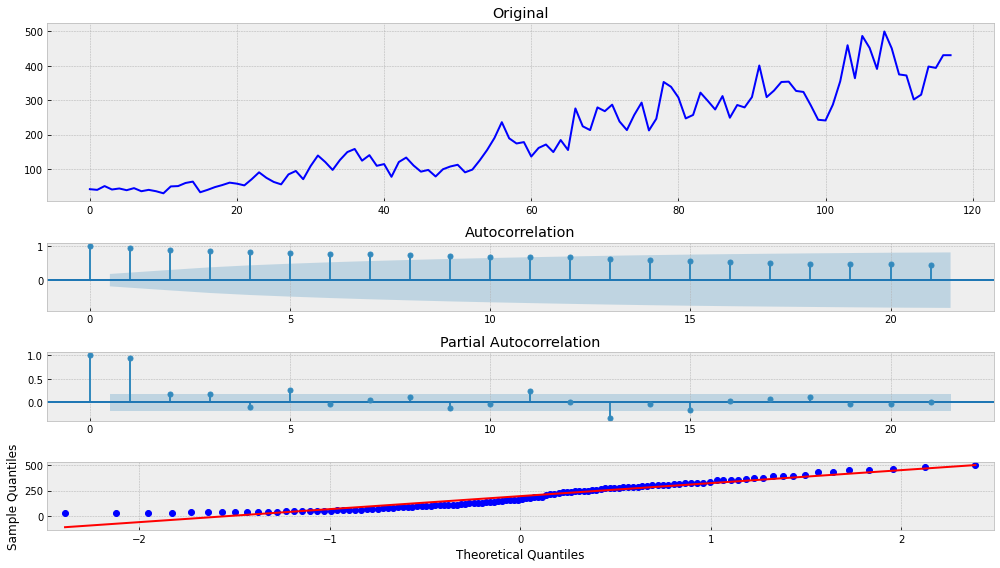

In [9]:
tsplot(series)

Для скрытой модели Маркова нужно привести ряд к стационарному по следующему соображению: скрытых переменных ограниченное количество и они обучаются под текущие значения временного ряда, в случае наличи трендов и сезонностей модель не сможет учесть новые уровни значений, так как они ей не известны.

Приведем к стационарному рядом с помощью дифференцирования первого уровня.

Results of Dickey-Fuller Test:
Test Statistic                -7.428564e+00
p-value                        6.450795e-11
#Lags Used                     1.000000e+01
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64


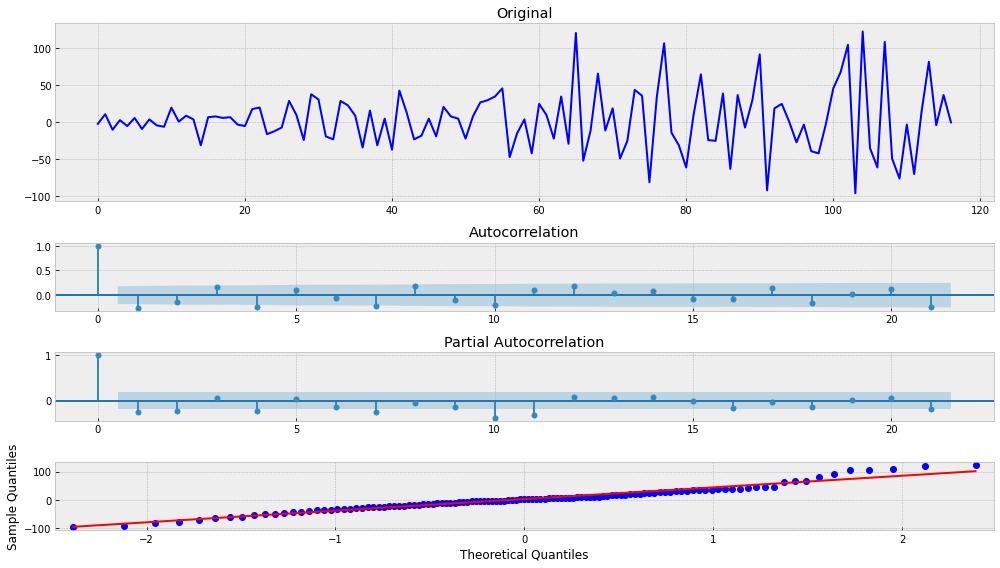

In [10]:
series_diff = np.diff(series, 1)
tsplot(series_diff)

Теперь обучим нашу модель GaussianHMM

In [11]:
model = GaussianHMM(n_components=80, n_iter=100, tol=1e-6)
values = np.reshape(series_diff, [len(series_diff), 1])
model.fit(values)

labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]

Fitting a model with 6559 free scalar parameters with only 117 data points will result in a degenerate solution.


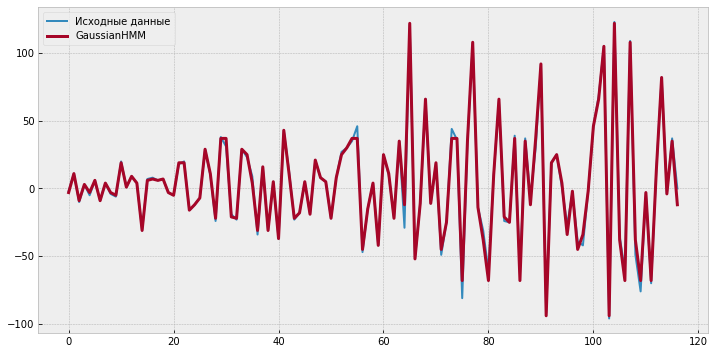

In [12]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 6))
    plt.plot(values, label='Исходные данные')
    plt.plot(means, label='GaussianHMM', linewidth=3)
    plt.legend()
    plt.show()

Как видно модель хорошо справилась с оценкой текущих данных.

Попробуем предсказать временной ряд на будущие значения пять раз.

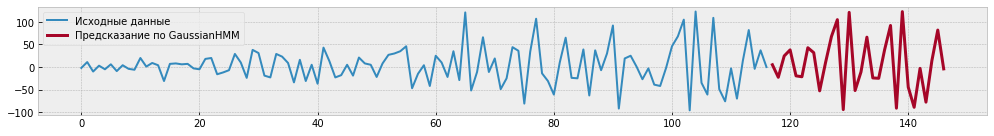

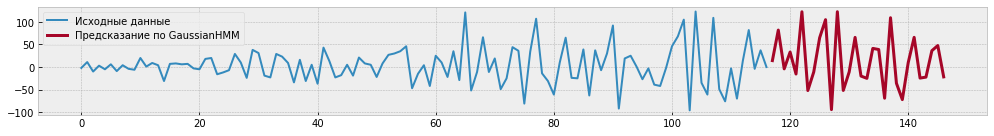

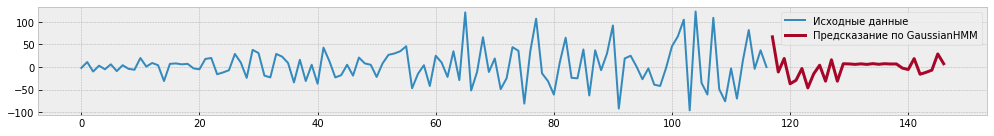

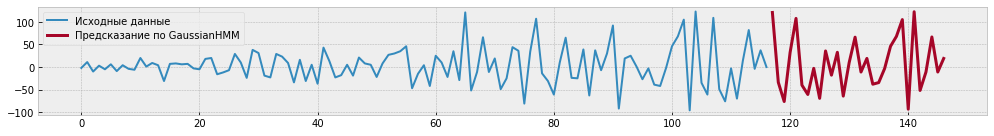

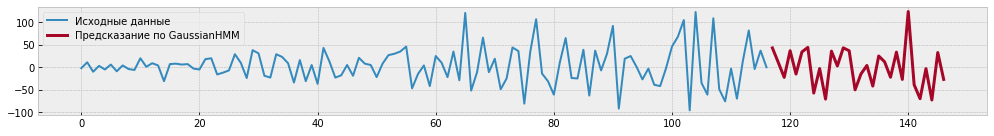

In [13]:
for _ in range(5):
    pred = pd.Series([None for i in range(len(series_diff))])
    pred = pred.append(pd.Series(np.ravel(model.sample(len(values)+30)[0][len(values):])), ignore_index=True)
    with plt.style.context('bmh'):
        plt.figure(figsize=(17, 2))
        plt.plot(values, label='Исходные данные')
        plt.plot(pred, label='Предсказание по GaussianHMM', linewidth=3)
        plt.legend()
        plt.show()

Как видно из полученных графиков, скрытую модель Маркова не получится применять для предсказания данного временного ряда. Так как будущие значения фактически выбираются случайным образом на основе матрицы вероятностей перехода. И следующее значение зависит только от предыдущего, у модели нет временной памяти. 